## 0. Классический импорт библиотек:

In [1]:
#Классический набор
import numpy as np
import pandas as pd

#Всякая графика
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16, 8)

#Декомпозиция
from statsmodels.tsa.seasonal import seasonal_decompose

#Всякая статистика
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

#Автокорреляция
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

#Модельки
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima.arima import ADFTest
from pmdarima.arima import auto_arima
from statsmodels.tsa.api import ExponentialSmoothing

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

from prophet import Prophet

#Метрика качества
from sklearn.metrics import mean_squared_error
import math


import itertools
import warnings

## 1. Чтение файла и обзор данных

In [2]:
df = pd.read_csv("data_train_NNFormat.csv", 
                 parse_dates=True, 
                 index_col="timestamp")
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6024 entries, 2019-01-01 00:00:00 to 2019-09-08 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   fact    6024 non-null   float64
dtypes: float64(1)
memory usage: 94.1 KB


Всего 6 024 наблюдений и соответственно 2 столбца: время (которое переместилось в индекс) и количество потреблённой электроэнергии. 

In [3]:
df

,fact
timestamp,
2019-01-01 00:00:00,294.0
2019-01-01 01:00:00,292.0
2019-01-01 02:00:00,290.0
2019-01-01 03:00:00,293.0
2019-01-01 04:00:00,294.0
...,...
2019-09-08 19:00:00,253.0
2019-09-08 20:00:00,263.0
2019-09-08 21:00:00,261.0


In [4]:
df.describe()

,fact
count,6024.000000
mean,511.303121
std,175.707942
min,158.000000
25%,356.000000
50%,503.000000
75%,654.000000
max,1015.000000


Посмотрим на пропуски в данных (мало ли):

In [5]:
df.isnull().sum()

fact    0
dtype: int64

Всё хорошо, пропусков нет

## 2. Визуализация

Визуализировать ряд с таким большим количеством наблюдений разом не лучшая идея, но всё же

<AxesSubplot:xlabel='timestamp', ylabel='fact'>

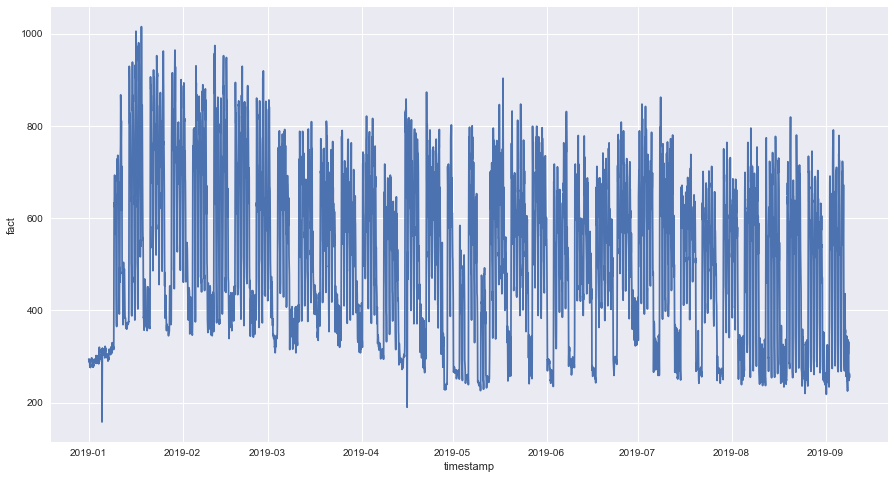

In [6]:
plt.figure(figsize = (15,8))
sns.lineplot(x = 'timestamp', y = 'fact',data = df)

Предварительно можно сказать:
* В начале января потребление было небольшим (вероятно это связано с "новогодними каникулами", то есть когда на предприятии не производятся какие-либо работы, то потребление электроэнергии снижается. Логично). 
* Зимой потребление электроэнергии выше (логично), с марта по середину апреля наблюдается спад. 
* В начале мая и ближе к 9-10-ым числам опять наблюдается спад. Очевидно. Это праздничные дни. 
* Мультипликативную модель отсекаем, так как размах колебаний не увеличивается.
* Присутствует явная сезонность внутри каждой недели, то есть по выходным снижение потребления электроэнергии.
* Возможна сезонность в рамках месяцев (квартал например, ну и время года естественно).
* На первый взгляд ряд может быть стационарным
* Следует проанализировать потребление в рамках времени суток, но пока сказать сложно. Нужно смотреть ближе.

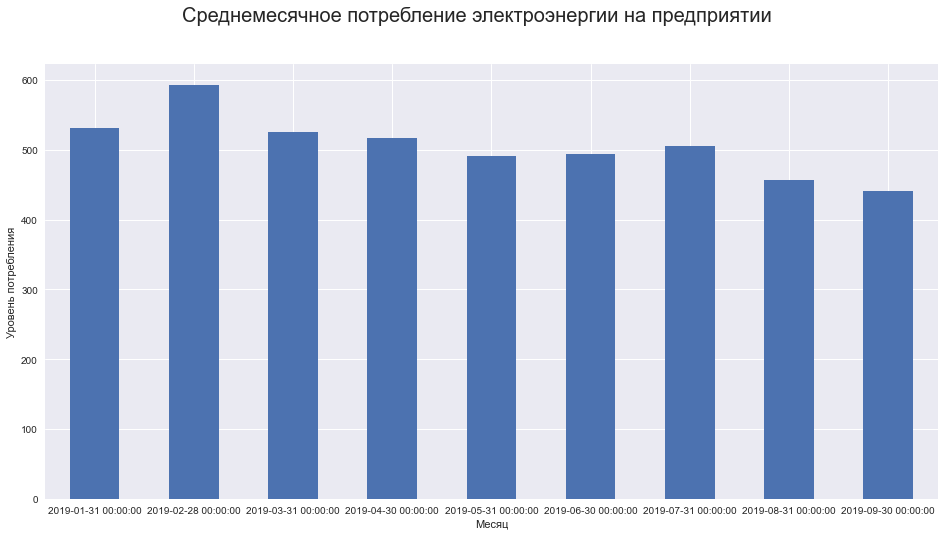

In [7]:
df_month = df.fact.resample('M').mean()
df_month.plot(kind='bar', label='_nolegend_');
plt.suptitle('Среднемесячное потребление электроэнергии на предприятии', fontsize=20);
plt.xlabel('Месяц', loc='center');
plt.ylabel('Уровень потребления', loc='center');
plt.xticks(rotation = -360);
ax = plt.gca();

В феврале наблюдается самое большое значение среднего, весной заметно снижение, в июне-июле рост, в августе и сентябре снижение.

Text(0.5, 0, 'Месяц')

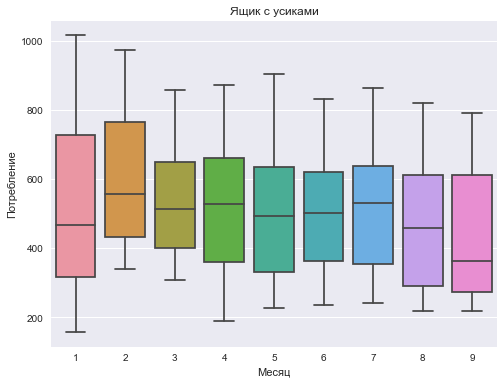

In [8]:
df_mo=df.copy()
df_mo = df_mo.reset_index()
df_mo['month'] = df_mo['timestamp'].dt.month

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=df_mo, x='month', y='fact', ax=ax)
ax.set_ylabel("Потребление")
ax.set_title('Ящик с усиками')
ax.set_xlabel("Месяц")

Стоит отметить, что ящик с усами не определил выбросов. В целом выводы по месяцам аналогичные. Рассмотрим их отдельно:

In [9]:
df_Jan = df.loc['2019-01-01':'2019-01-31']
df_Feb = df.loc['2019-02-01':'2019-02-28']
df_Mar = df.loc['2019-03-01':'2019-03-31']
df_Apr = df.loc['2019-04-01':'2019-04-30']
df_May = df.loc['2019-05-01':'2019-05-31']
df_Jun = df.loc['2019-06-01':'2019-06-30']
df_Jul = df.loc['2019-07-01':'2019-07-31']
df_Aug = df.loc['2019-08-01':'2019-08-31']
df_Sep = df.loc['2019-09-01':'2019-09-09']

<AxesSubplot:xlabel='timestamp', ylabel='fact'>

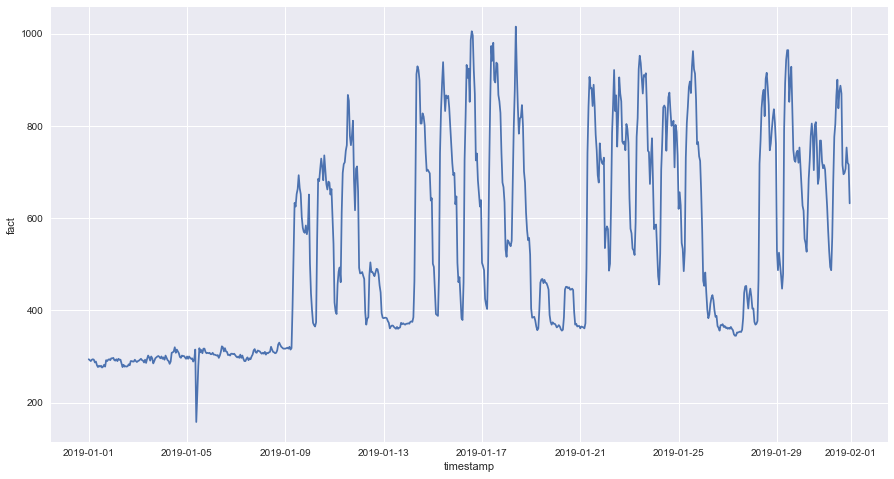

In [10]:
plt.figure(figsize = (15,8))
sns.lineplot(x = 'timestamp', y = 'fact',data = df_Jan)

Период с 1 по 9 января - праздничные дни. Вероятно их стоит убрать из рассмотрения. Спады потребления в выходные дни (12-13,19-20, 26-27). Спады в ночное время суток.

<AxesSubplot:xlabel='timestamp', ylabel='fact'>

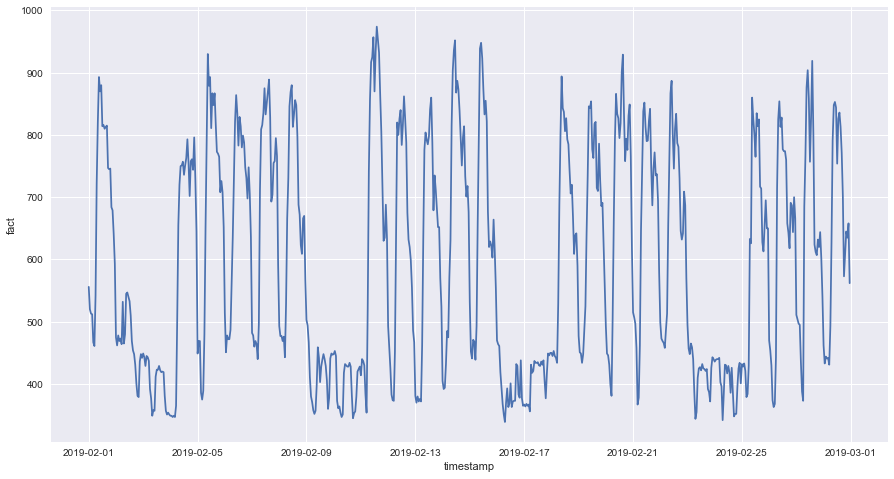

In [11]:
plt.figure(figsize = (15,8))
sns.lineplot(x = 'timestamp', y = 'fact',data = df_Feb)

23 февраля выпало на выходной. Не повезло :)

<AxesSubplot:xlabel='timestamp', ylabel='fact'>

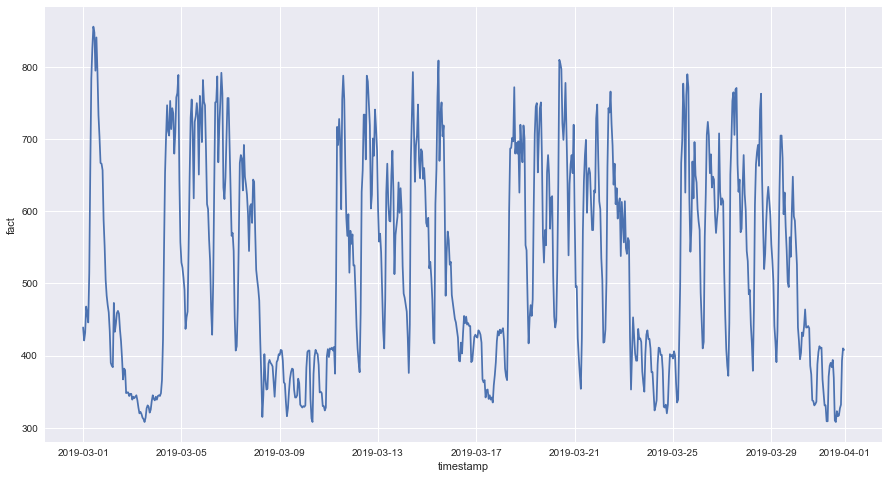

In [12]:
plt.figure(figsize = (15,8))
sns.lineplot(x = 'timestamp', y = 'fact',data = df_Mar)

<AxesSubplot:xlabel='timestamp', ylabel='fact'>

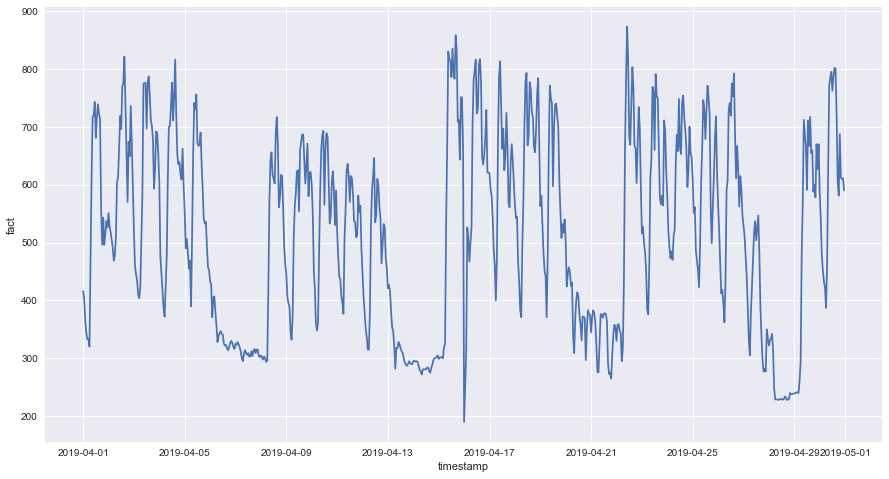

In [13]:
plt.figure(figsize = (15,8))
sns.lineplot(x = 'timestamp', y = 'fact',data = df_Apr)

<AxesSubplot:xlabel='timestamp', ylabel='fact'>

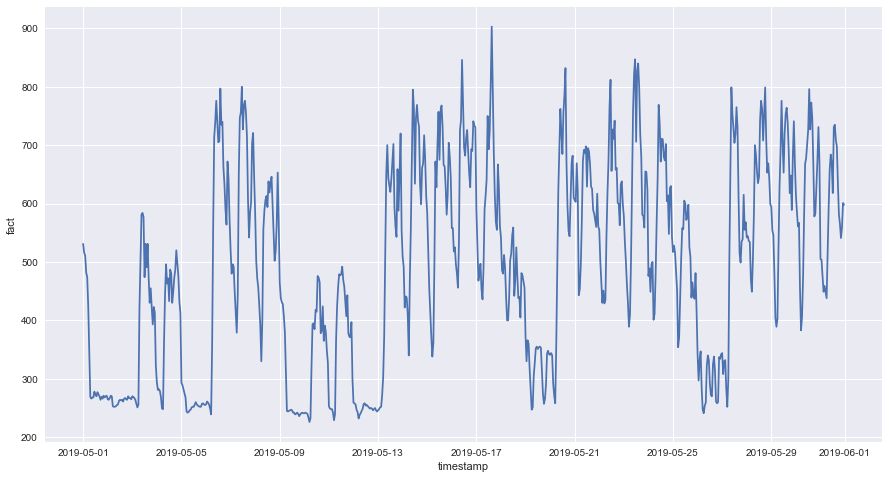

In [14]:
plt.figure(figsize = (15,8))
sns.lineplot(x = 'timestamp', y = 'fact',data = df_May)

1-2 мая праздники.9-10 аналогично.

<AxesSubplot:xlabel='timestamp', ylabel='fact'>

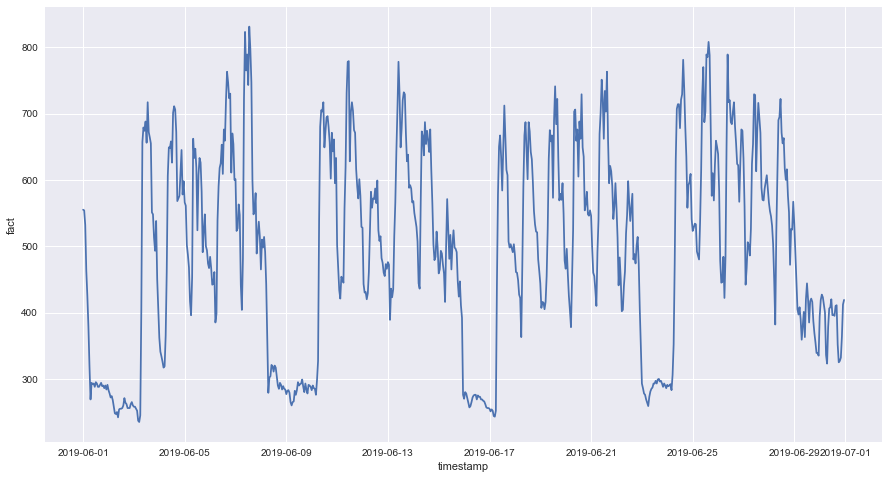

In [15]:
plt.figure(figsize = (15,8))
sns.lineplot(x = 'timestamp', y = 'fact',data = df_Jun)

12-го июня наблюдается небольшой спад. Праздничный день. 

<AxesSubplot:xlabel='timestamp', ylabel='fact'>

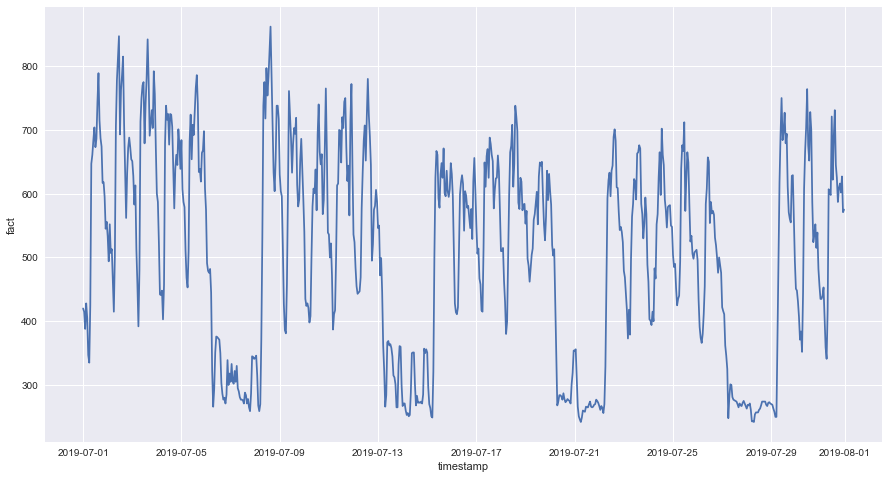

In [16]:
plt.figure(figsize = (15,8))
sns.lineplot(x = 'timestamp', y = 'fact',data = df_Jul)

<AxesSubplot:xlabel='timestamp', ylabel='fact'>

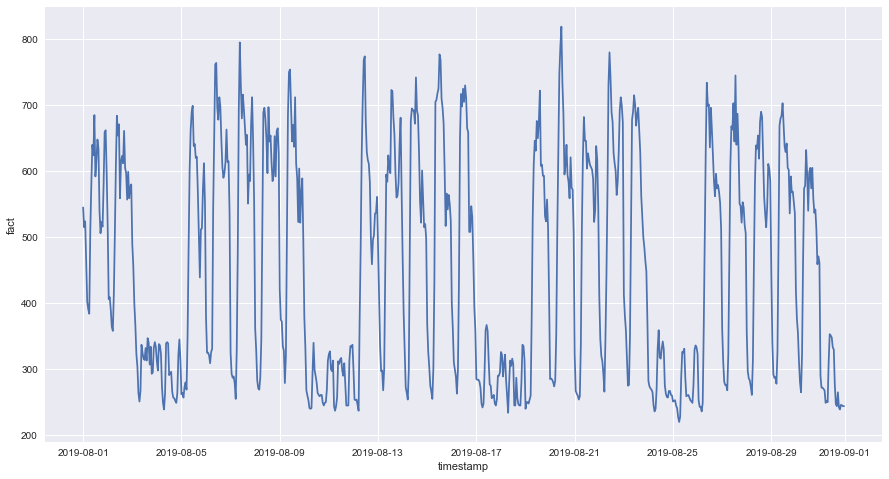

In [17]:
plt.figure(figsize = (15,8))
sns.lineplot(x = 'timestamp', y = 'fact',data = df_Aug)

<AxesSubplot:xlabel='timestamp', ylabel='fact'>

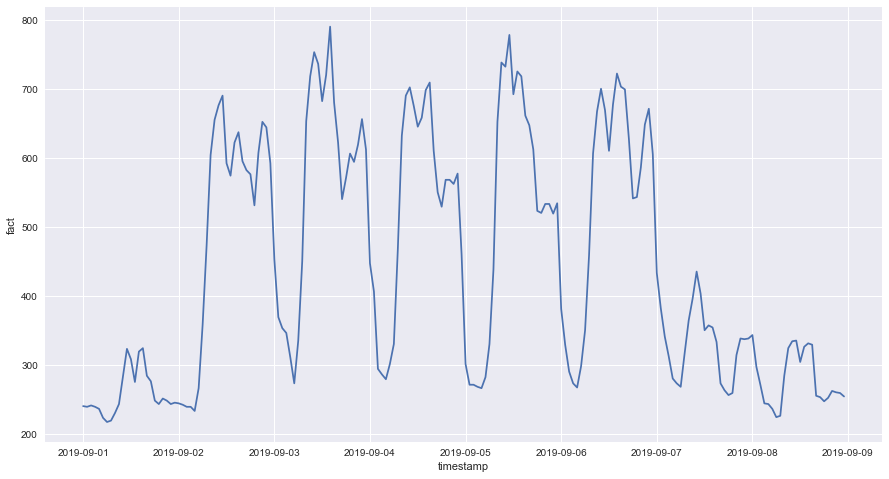

In [18]:
plt.figure(figsize = (15,8))
sns.lineplot(x = 'timestamp', y = 'fact',data = df_Sep)

1-е число - выходной (воскресенье), 7-8 выходные. Всё как и было выявлено ранее.

Выводы, которые были получены ранее, подтвердились. Теперь посмотрим разрез в неделях:

In [19]:
df_week=df.copy()
df_week = df_week.reset_index()
df_week['weekday'] = df_week['timestamp'].dt.weekday
df_week1 = df_week.groupby('weekday', as_index=False) \
                                        .agg({'fact':'mean'}) \
                                            .rename(columns={'fact':'Среднее потребление электроэнергии'})
weekdays = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
df_week1['weekday'] = weekdays.values()
df_week1['Среднее потребление электроэнергии'] = round(df_week1['Среднее потребление электроэнергии'])
df_week1 = df_week1.astype({'Среднее потребление электроэнергии':'int'})
df_week1

,weekday,Среднее потребление электроэнергии
0,Mon,560
1,Tue,589
2,Wed,583
3,Thu,580
4,Fri,568
5,Sat,382
6,Sun,319


C:\Users\Vitaly\anaconda3\envs\msa\lib\site-packages\pandas\plotting\_matplotlib\core.py:633: UserWarning: The handle <BarContainer object of 7 artists> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


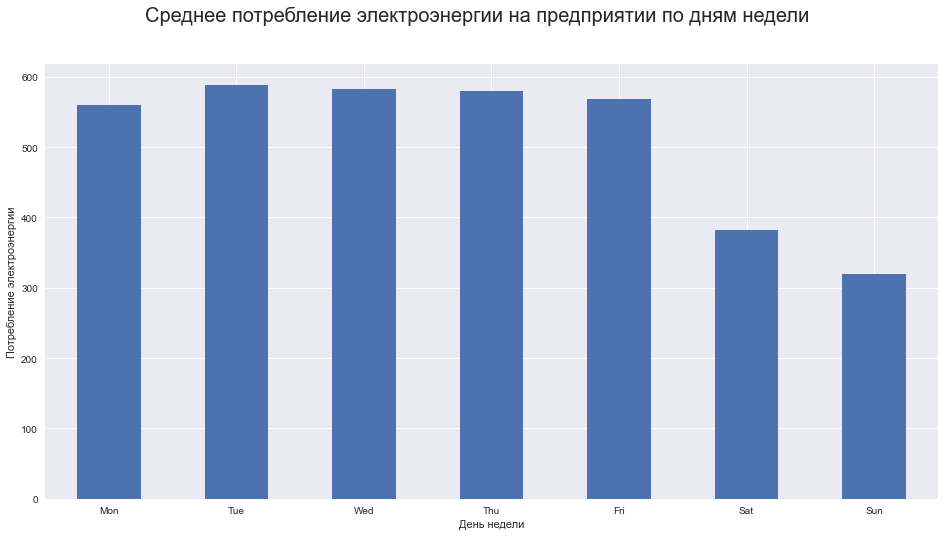

In [20]:
df_week1.plot(x='weekday', y='Среднее потребление электроэнергии', kind='bar', label='_nolegend_');
plt.suptitle('Среднее потребление электроэнергии на предприятии по дням недели', fontsize=20);
plt.xlabel('День недели', loc='center');
plt.ylabel('Потребление электроэнергии', loc='center');
plt.xticks(rotation = -360);
ax = plt.gca()

В субботу-воскресенье выходные, потребление снижается более чем в 1,5 раза по сравнению с рабочими днями. В понедельник потребление ниже, чем в другие рабочие дни. Самое большое среднее значение потребления во вторник, затем потребление снижается.

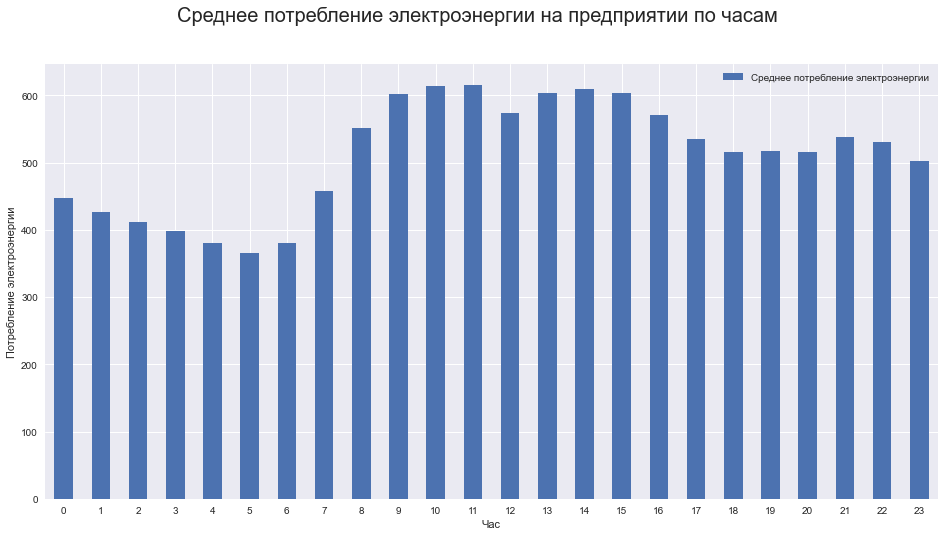

In [21]:
df_day=df.copy()
df_day = df_day.reset_index()
df_day['hour'] = df_day['timestamp'].dt.hour
df_day1 = df_day.groupby('hour', as_index=False) \
                                        .agg({'fact':'mean'}) \
                                            .rename(columns={'fact':'Среднее потребление электроэнергии'})
df_day1['Среднее потребление электроэнергии'] = round(df_day1['Среднее потребление электроэнергии'])
df_day1 = df_day1.astype({'Среднее потребление электроэнергии':'int'})

df_day1.plot(x='hour', y='Среднее потребление электроэнергии', kind='bar');
plt.suptitle('Среднее потребление электроэнергии на предприятии по часам', fontsize=20);
plt.xlabel('Час', loc='center');
plt.ylabel('Потребление электроэнергии', loc='center');
plt.xticks(rotation = -360);
ax = plt.gca()

Снижение потребления электроэнергии начинается с 11 часов ночи до 6 часов утра. После 6-ти наблюдается резкое увеличение потребления, которое снижается в 12-13 часов (видимо обед), в 2 часа дня вновь увеличение потребления, затем постапенный спад. Хотя в 9 часов снова увеличивается потребление.

In [22]:
df_day_of_week=df.copy()
df_day_of_week = df_day_of_week.reset_index()
df_day_of_week['hour'] = df_day_of_week['timestamp'].dt.hour
df_day_of_week['weekday'] = df_day_of_week['timestamp'].dt.weekday

df_day_of_week1 = df_day_of_week.groupby(['weekday', 'hour'], as_index=False)\
                                        .agg({'fact':'mean'}) \
                                            .rename(columns={'fact':'Среднее потребление электроэнергии'})
df_day_of_week1['Среднее потребление электроэнергии'] = round(df_day_of_week1['Среднее потребление электроэнергии'])
df_day_of_week1 = df_day_of_week1.astype({'Среднее потребление электроэнергии':'int'})


df_day_of_week1

,weekday,hour,Среднее потребление электроэнергии
0,0,0,329
1,0,1,326
2,0,2,321
3,0,3,317
4,0,4,307
...,...,...,...
163,6,19,299
164,6,20,311
165,6,21,332
166,6,22,337


<AxesSubplot:>

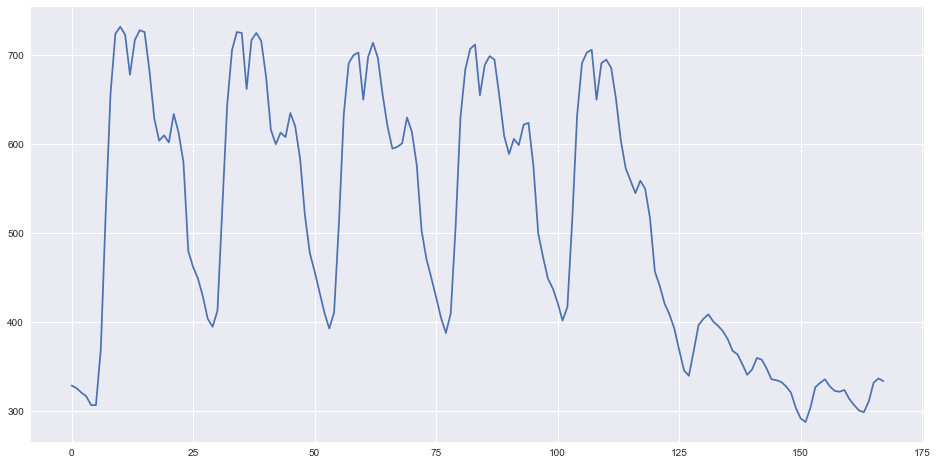

In [23]:
df_day_of_week1['Среднее потребление электроэнергии'].plot()

На этом графике четче видно, что присутствует явная сезонность. Все выводы, полученные ранее подтверждаются.

### Декомпозиция ряда

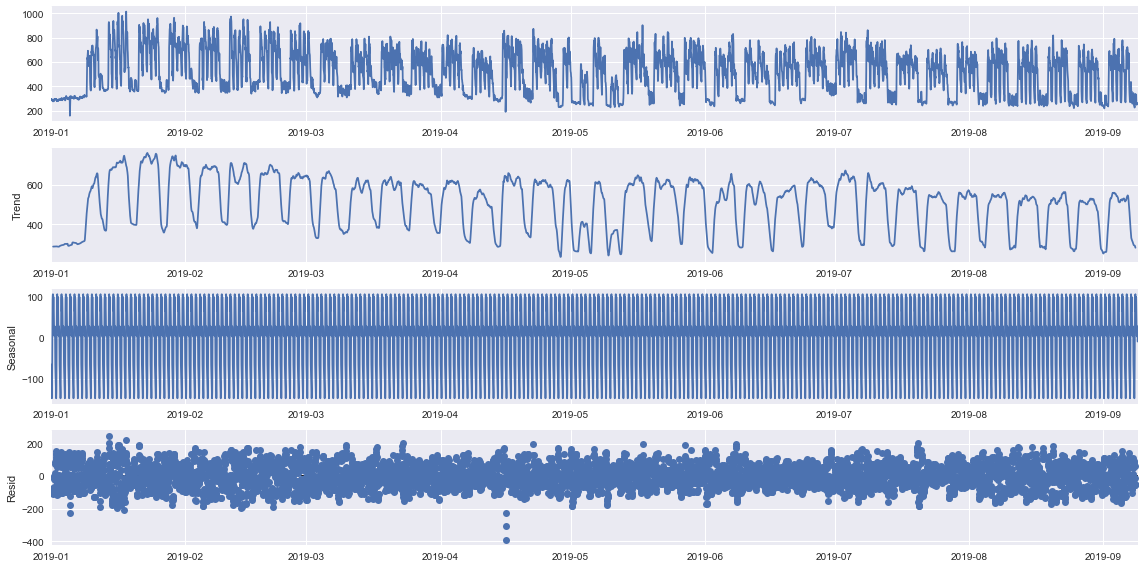

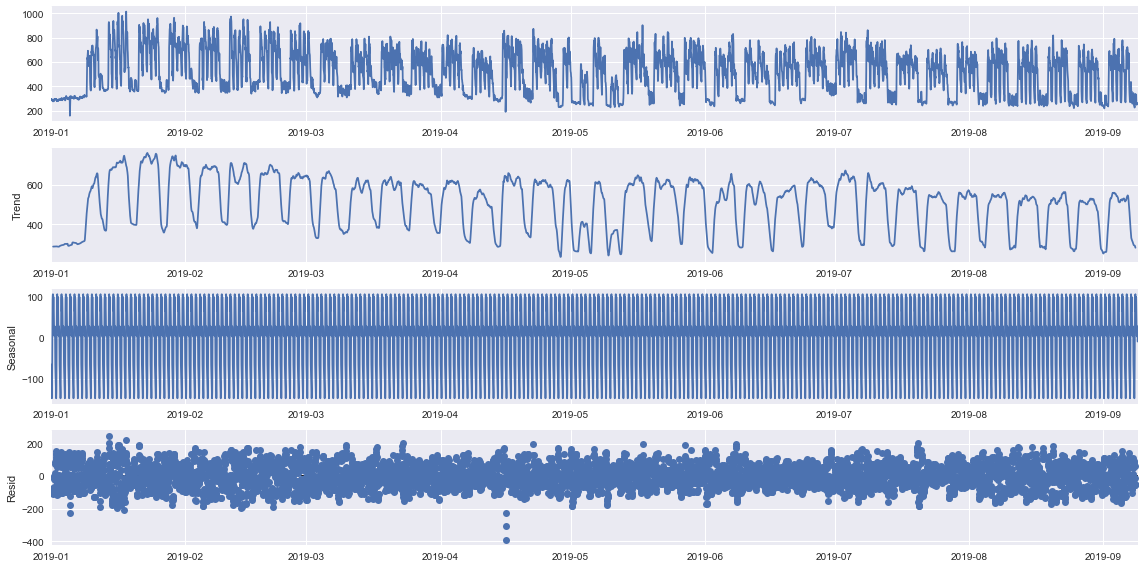

In [24]:
decompose = seasonal_decompose(df, model='additive')
decompose.plot()

Четкого тренда (тенденции на увеличение или уменьшение не наблюдается). Явная сезонность.

## 3. Немножко про статистику

Посмотрим на распределение потребления электроэнергии:

array([[<AxesSubplot:title={'center':'fact'}>]], dtype=object)

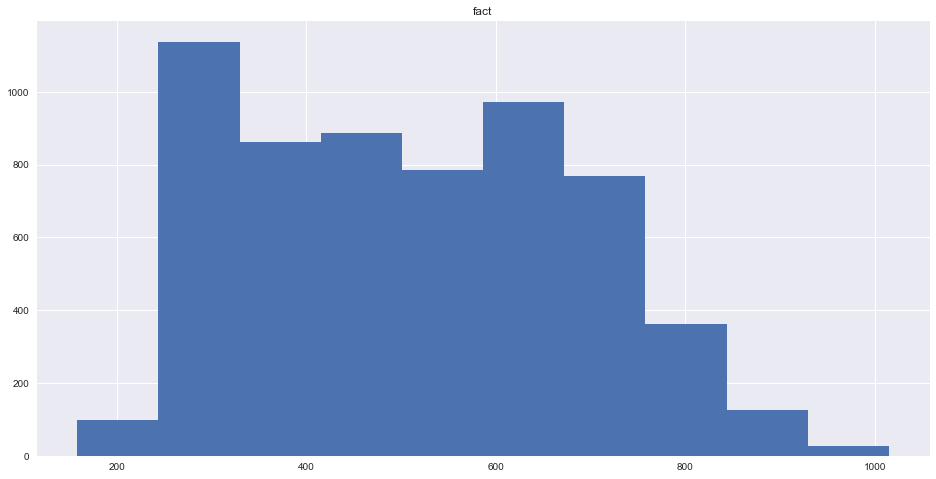

In [25]:
df.hist()

Визуально не то чтобы похоже на нормальное распределение.

In [26]:
alpha = 0.05

___H0___: Потребление электроэнергии распределено нормально.

Тест Колмогорова-Смирнова: 

In [27]:
stat, p = stats.kstest(df['fact'], 'norm')
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
if p > alpha:
    print(f'H0 не отвергается с вероятностью {1-alpha}')
else:
    print(f'H0 отвергается с вероятностью {1-alpha}')

Statistics=1.000, p-value=0.000
H0 отвергается с вероятностью 0.95


Тест Жарка — Бера:

In [28]:
jarque_bera_test = stats.jarque_bera(df)
jarque_bera_test

Jarque_beraResult(statistic=279.2283332673443, pvalue=0.0)

p-value меньше заданного порога => гипотеза H0 отвергается

Проверка ряда на стационарность:

___H0___: Исследуемый ряд нестационарен

Тест Дики-Фуллера:

In [29]:
adf_test = adfuller(df['fact'])
print('p-value = ' + str(adf_test[1]))

p-value = 1.118897383625658e-19


p-value меньше заданного порога => гипотеза отвергается

In [30]:
test = sm.tsa.adfuller(df['fact'])
print(f'adf: {round(test[0], 4)}')
print(f'p-value: {test[1]}')
print(f'Critical values: {test[4]}')
if test[0] > test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf: -10.9074
p-value: 1.118897383625658e-19
Critical values: {'1%': -3.4314408956603097, '5%': -2.8620220755599486, '10%': -2.5670266063699962}
единичных корней нет, ряд стационарен


Таким образом, ряд является стационарным, то есть временной ряд не имеет тренда. Стационарность - хорошо.

## 4. Автокорреляция

In [31]:
aft = sm.tsa.acf(df['fact'], nlags=336)
df_aft = pd.DataFrame(aft,columns=['Aft'])

In [32]:
df_aft1=df_aft.loc[(df_aft['Aft'] > 0.5)]
df_aft1.sort_values(by='Aft',ascending=False)

,Aft
0,1.000000
1,0.950092
2,0.866943
168,0.784448
3,0.775547
167,0.757315
169,0.755778
166,0.695428
170,0.692180
4,0.691027


In [33]:
df_aft1

,Aft
0,1.000000
1,0.950092
2,0.866943
3,0.775547
4,0.691027
5,0.616492
6,0.545743
23,0.534295
24,0.553633
25,0.522109


<AxesSubplot:>

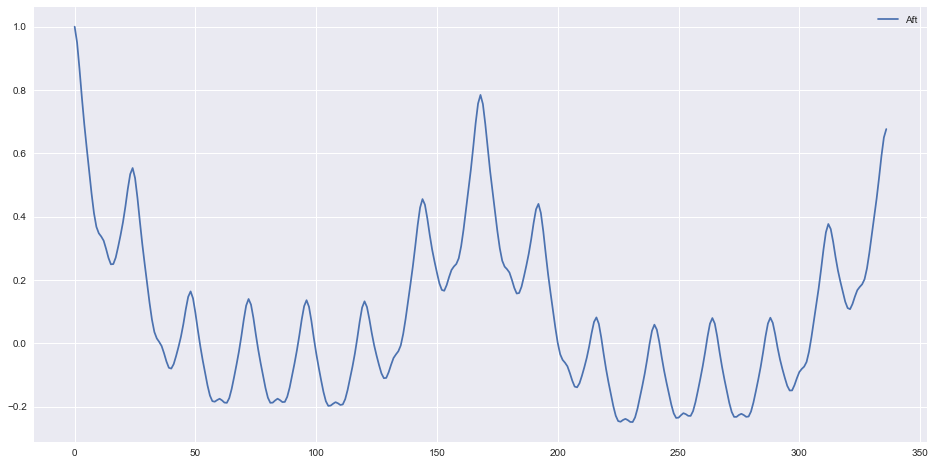

In [34]:
df_aft.plot()

По значениям автокорреляции можно выявить сезонность. В данном случае четко видно, что на 168 лаге корреляция большая, то есть присутствует недельная сезонность. Замечательно. 336 лаг, то есть вторая неделя, аналогично имеет довольно большое значение (0.68). Посуточная сезонность также виднеется (0.55)

C:\Users\Vitaly\anaconda3\envs\msa\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


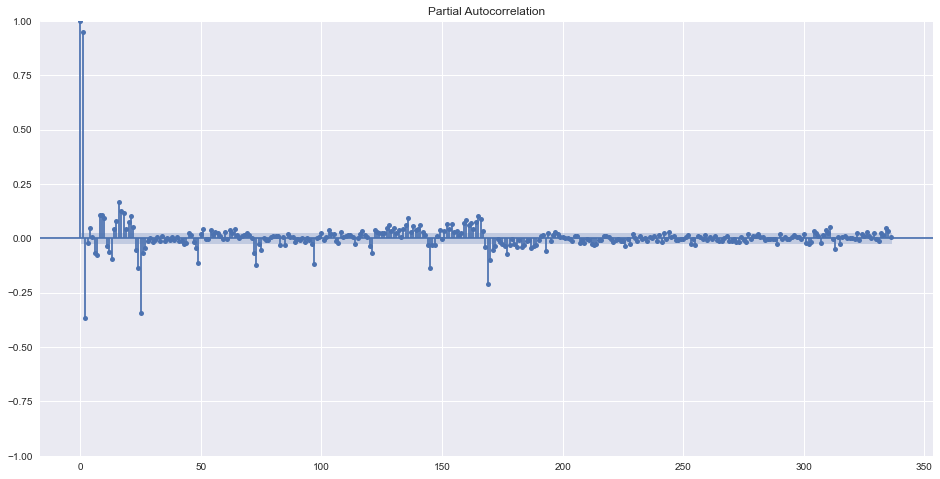

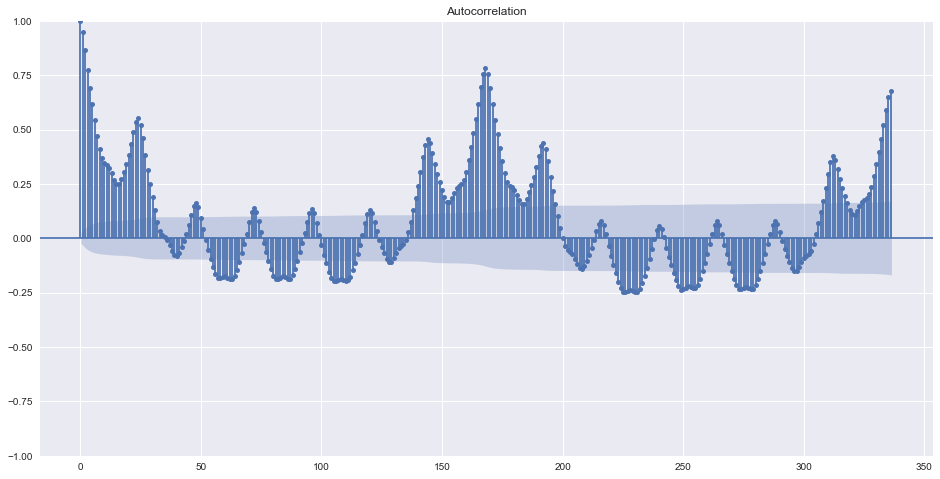

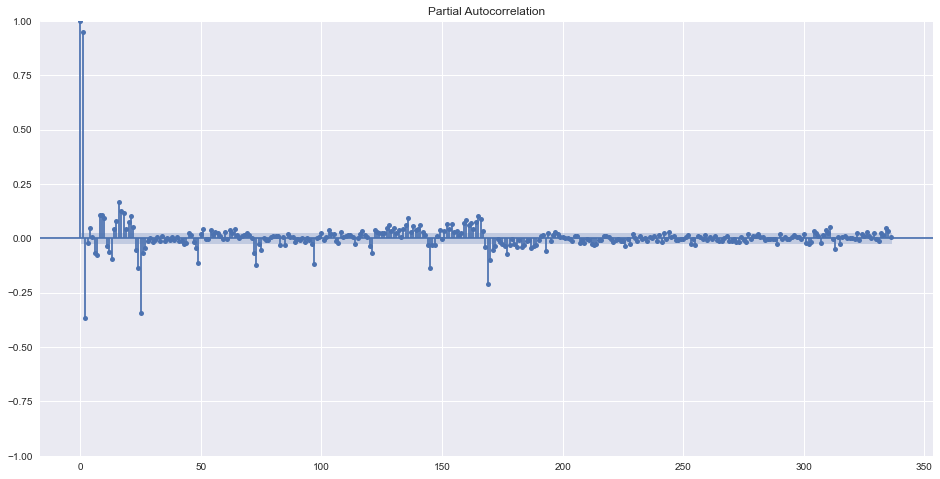

In [35]:
plot_acf(df['fact'], lags=336)
plot_pacf(df['fact'], lags=336)

## 5. Перебор моделей

Перед началом работы необходимо разделить данные на обучающую и тестовую выборки. Следует отметить, что первые 9 дней января лучше убрать из рассмотрения, так как эти дни были праздничными. К тестовой выборке отнесём все данные по сентябрю и две последние недели августа.

In [36]:
df_train = df[192:5352]
df_test= df[5352:]

In [37]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5160 entries, 2019-01-09 00:00:00 to 2019-08-11 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   fact    5160 non-null   float64
dtypes: float64(1)
memory usage: 80.6 KB


In [38]:
df_train

,fact
timestamp,
2019-01-09 00:00:00,317.0
2019-01-09 01:00:00,318.0
2019-01-09 02:00:00,319.0
2019-01-09 03:00:00,317.0
2019-01-09 04:00:00,321.0
...,...
2019-08-11 19:00:00,245.0
2019-08-11 20:00:00,313.0
2019-08-11 21:00:00,335.0


In [39]:
df_train.index = pd.DatetimeIndex(df_train.index.values,
                               freq='H')

In [40]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 672 entries, 2019-08-12 00:00:00 to 2019-09-08 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   fact    672 non-null    float64
dtypes: float64(1)
memory usage: 10.5 KB


In [41]:
df_test

,fact
timestamp,
2019-08-12 00:00:00,299.0
2019-08-12 01:00:00,254.0
2019-08-12 02:00:00,253.0
2019-08-12 03:00:00,254.0
2019-08-12 04:00:00,246.0
...,...
2019-09-08 19:00:00,253.0
2019-09-08 20:00:00,263.0
2019-09-08 21:00:00,261.0


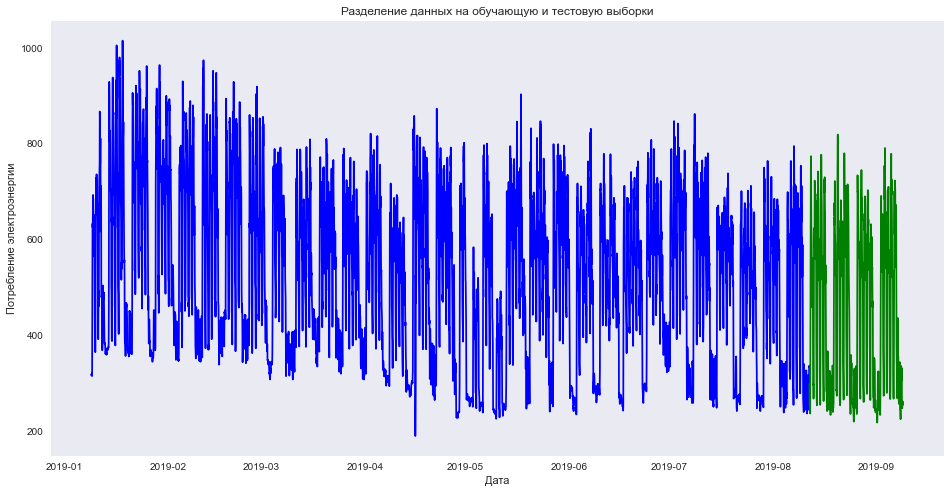

In [42]:
plt.plot(df_train, color = "blue")
plt.plot(df_test, color = "green")
plt.title('Разделение данных на обучающую и тестовую выборки')
plt.ylabel('Потребление электроэнергии')
plt.xlabel('Дата')
plt.grid()
plt.show()

### 5.0 Модель ARIMA

In [43]:
model = ARIMA(df_train,order=(2,1,1), enforce_stationarity = False, enforce_invertibility = False)
model_0 = model.fit()

In [44]:
model_0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   fact   No. Observations:                 5160
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -27652.976
Date:                Fri, 24 Jun 2022   AIC                          55313.953
Time:                        06:24:45   BIC                          55340.145
Sample:                    01-09-2019   HQIC                         55323.118
                         - 08-11-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2761      0.011    119.437      0.000       1.255       1.297
ar.L2         -0.3510      0.010    -35.620      0.000      -0.370      -0.332
ma.L1         -1.0018      0.001  -1038.708      0.000      -1.004      -1.000
sigma2      2648.7029     35.687     74.221      0.000    2578.758    2718.648
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):              2272.64
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
pred_0 = model_0.predict(start='2019-08-12 00:00:00', end='2019-09-08 23:00:00')

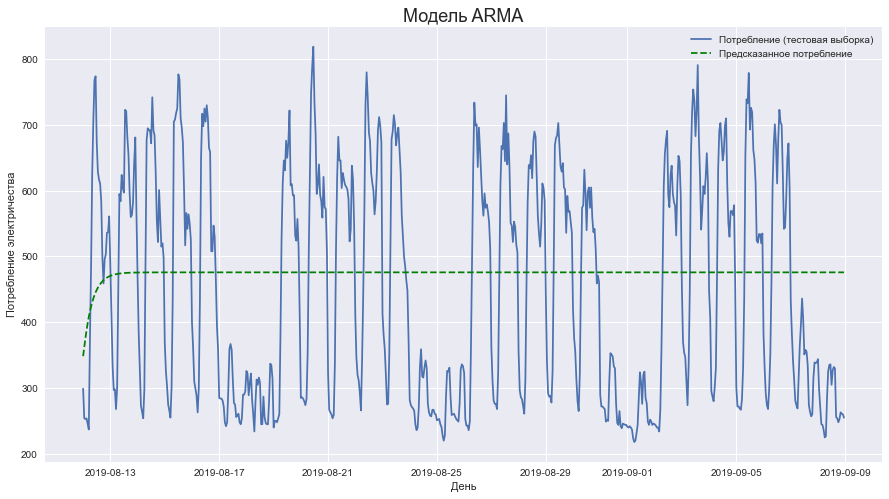

In [46]:
plt.figure(figsize=(15, 8))
plt.plot(df_test);
plt.plot(pred_0, 'g--');
plt.legend(['Потребление (тестовая выборка)', 'Предсказанное потребление'])
plt.xlabel('День')
plt.ylabel('Потребление электричества')
plt.title('Модель ARIMA', size=18);

In [47]:
MSE_2 = mean_squared_error(df_test, pred_0)
 
RMSE_2 = math.sqrt(MSE_2)
print("Root Mean Square Error:\n")
print(RMSE_2)

Root Mean Square Error:

173.2644026737276


Арима так себе справляется. Пойдём дальше

### 5.1 Модель SARIMAX

К сожалению мой несчастный ноутбук не вывозит перебор параметров. Поэтому я вынуждена подбирать параметры самостоятельно. 

In [49]:
model_1 = sm.tsa.statespace.SARIMAX(df_train, order=(2, 1, 1), seasonal_order=(2, 0, 1, 24), enforce_stationarity = False, enforce_invertibility = False)
model_1 = model_1.fit()

C:\Users\Vitaly\anaconda3\envs\msa\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [50]:
print(model_1.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0921      0.017     63.046      0.000       1.058       1.126
ar.L2         -0.1407      0.018     -8.010      0.000      -0.175      -0.106
ma.L1         -0.9993      0.003   -376.025      0.000      -1.004      -0.994
ar.S.L24       1.1254      0.018     64.308      0.000       1.091       1.160
ar.S.L48      -0.1280      0.017     -7.360      0.000      -0.162      -0.094
ma.S.L24      -0.9681      0.006   -158.174      0.000      -0.980      -0.956
sigma2      2753.3290     54.497     50.522      0.000    2646.517    2860.141


In [51]:
pred_1 = model_1.get_prediction(start=pd.to_datetime('2019-08-12 00:00:00'), end=pd.to_datetime('2019-09-08 23:00:00'), dynamic=False)
print(pred_1)

In [52]:
pred_1 = pred_1.predicted_mean
pred_1 = pd.DataFrame(pred_1).reset_index().rename(columns={'index':'date', 'predicted_mean':'fact'})

In [53]:
pred_1

,date,fact
0,2019-08-12 00:00:00,305.272176
1,2019-08-12 01:00:00,293.386274
2,2019-08-12 02:00:00,280.912942
3,2019-08-12 03:00:00,273.733067
4,2019-08-12 04:00:00,266.866425
...,...,...
667,2019-09-08 19:00:00,452.502638
668,2019-09-08 20:00:00,456.861670
669,2019-09-08 21:00:00,479.672073
670,2019-09-08 22:00:00,474.820064


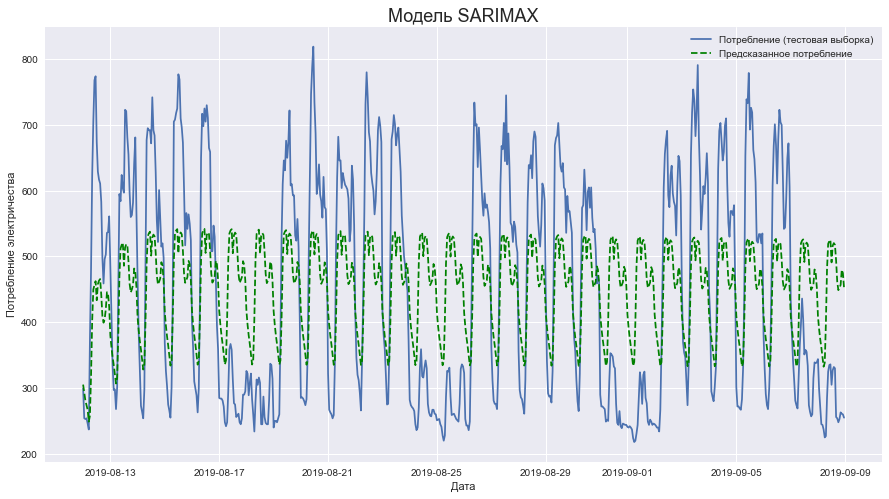

In [54]:
plt.figure(figsize=(15, 8))
plt.plot(df_test);
plt.plot(pred_1['date'], pred_1['fact'],'g--');
plt.legend(['Потребление (тестовая выборка)', 'Предсказанное потребление'])
plt.xlabel('Дата')
plt.ylabel('Потребление электричества')
plt.title('Модель SARIMAX', size=18);

Посмотрим по метрике качества:

In [55]:
MSE_1 = mean_squared_error(df_test, pred_1['fact'])
 
RMSE_1 = math.sqrt(MSE_1)
print("Root Mean Square Error:\n")
print(RMSE_1)

Root Mean Square Error:

141.15923803036418


Уже лучше, но всё равно модель не так уж хорошо описывает сезонность. Хотелось бы взять период 168 (неделя), но к сожалению мой ноутбук не выдерживает (машина считала около 5-ти часов, и я сдалась)

### 5.2 Модель Хольта-Винтерса (тройное экспоненциальное сглаживание – учет сезонности)

Обзор данных показал, что период колебаний стоит брать либо 24, либо 168, либо 336 (автокорреляция). Также не было выявлено мультипликативной составляющей колебаний. И явного тренда. 

In [56]:
model_2 = ExponentialSmoothing(df_train, seasonal_periods=336, trend=None, seasonal='add').fit()

*Модель строилась несколько раз на основе трёх вышеперечисленных периодов. Отобрана лучшая комбинация*

In [57]:
model_2.params

{'smoothing_level': 0.8813070912787766,
 'smoothing_trend': nan,
 'smoothing_seasonal': 0.11317377347881614,
 'damping_trend': nan,
 'initial_level': 563.258271819447,
 'initial_trend': nan,
 'initial_seasons': array([  -2.88201926,  -54.35921731,  -64.63751826,  -85.4494406 ,
         -96.36962602, -100.32333244,  -73.28182532,   34.11813255,
         147.73340192,  239.16305375,  256.83421645,  253.65557856,
         212.73570023,  241.53924086,  247.30886067,  246.65513184,
         226.80313017,  184.97749298,  137.6428851 ,  134.74015663,
         144.78496359,  163.82220422,  132.13360128,   96.43702849,
           1.70201805,  -52.04212174,  -71.79945262,  -90.96108933,
        -120.88229268, -132.45732885, -114.00167027,    9.0991736 ,
         133.61780442,  191.14381917,  220.93538664,  218.04705655,
         172.88412018,  190.70003089,  212.67407267,  222.58525833,
         180.23647495,  123.37291793,  108.00832763,  130.70276254,
         111.13385081,  145.16374013,  141

In [58]:
pred_2 = model_2.predict(start='2019-08-12 00:00:00', end='2019-09-08 23:00:00')

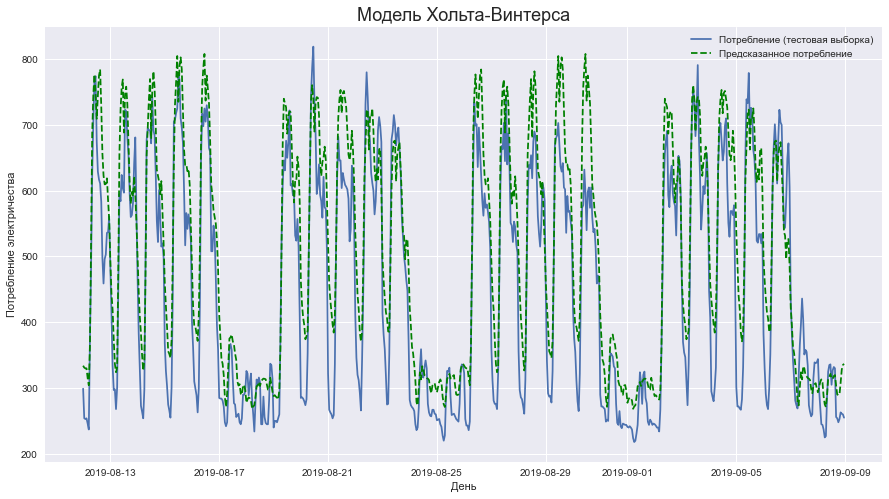

In [59]:
plt.figure(figsize=(15, 8))
plt.plot(df_test);
plt.plot(pred_2, 'g--');
plt.legend(['Потребление (тестовая выборка)', 'Предсказанное потребление'])
plt.xlabel('День')
plt.ylabel('Потребление электричества')
plt.title('Модель Хольта-Винтерса', size=18);

Ну выглядит... симпатично.

Оценим качество по метрике:

In [60]:
MSE_2 = mean_squared_error(df_test, pred_2)
 
RMSE_2 = math.sqrt(MSE_2)
print("Root Mean Square Error:\n")
print(RMSE_2)

Root Mean Square Error:

74.71364817537147


Значение метрики тоже радует глаз.

### 5.3 Модель Prophet

In [61]:
df_3 = df.copy().rename(columns={'fact':'y'})

In [62]:
df_3['ds'] = df_3.index

Список праздников:

In [63]:
holidays = pd.DataFrame({
  'holiday': 'holy',
  'ds': pd.to_datetime(['2019-03-08', '2019-05-01','2019-05-02', '2019-05-09', '2019-05-10', '2019-06-12']),
  'lower_window': 0,
  'upper_window': 1,
})

Создаём регрессоры:

In [64]:
df_3['reg1'] = 0

Обычно пик работы приходится на дневное время суток. Самое большое значение потребления энергии примерно в 11 часов.

In [65]:
df_3['reg1'] = [1 if df_3['ds'][i].hour == 11 else 0 for i in df_3['ds']]

Раз был разговор про недельную сезонность. Попробуем это учесть

In [66]:
df_3['reg2']=df_3['ds'].dt.weekday

В воскресенье самое низкое значение потребления электроэнергии на неделе.

In [67]:
df_3['reg3'] = 0
df_3['reg3'] = [1 if x==6 else 0 for x in df_3['reg2']]

А во вторник самое активное.

In [68]:
df_3['reg4'] = 0
df_3['reg4'] = [1 if x==1 else 0 for x in df_3['reg2']]

Разделяем данные на выборки:

In [69]:
df_train_3 = df_3[192:5352]
df_test_3 = df_3[5352:]

Строим модельку:

In [70]:
model_3 = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=True,holidays=holidays,
                  n_changepoints=25, changepoint_range=0.7, seasonality_prior_scale=50.0, changepoint_prior_scale=0.1)
model_3.add_seasonality(name = 'custom_h', period = 7, fourier_order=5)
model_3.add_regressor('reg1')
model_3.add_regressor('reg2')
model_3.add_regressor('reg3')
model_3.add_regressor('reg4')
model_3.add_country_holidays(country_name='RU')
model_3.fit(df_train_3)

Предсказываем:

In [71]:
pred_3 = model_3.make_future_dataframe(periods=672,freq='H')

In [72]:
pred_3

,ds
0,2019-01-09 00:00:00
1,2019-01-09 01:00:00
2,2019-01-09 02:00:00
3,2019-01-09 03:00:00
4,2019-01-09 04:00:00
...,...
5827,2019-09-08 19:00:00
5828,2019-09-08 20:00:00
5829,2019-09-08 21:00:00
5830,2019-09-08 22:00:00


In [73]:
pred_3['reg1'] = 0
for i in range(pred_3.shape[0]):
    if pred_3['ds'][i].hour == 11:
        pred_3['reg1'][i] = 1
    else:
        pred_3['reg1'][i] = 0

C:\Users\Vitaly\anaconda3\envs\msa\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Vitaly\anaconda3\envs\msa\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [74]:
pred_3['reg2']=pred_3['ds'].dt.weekday

In [75]:
pred_3['reg3'] = 0
pred_3['reg3'] = [1 if x==6 else 0 for x in pred_3['reg2']]

In [76]:
pred_3['reg4'] = 0
pred_3['reg4'] = [1 if x==1 else 0 for x in pred_3['reg2']]

In [77]:
pred_3 = model_3.predict(pred_3)

In [78]:
pred_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5832 entries, 0 to 5831
Data columns (total 73 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   ds                                    5832 non-null   datetime64[ns]
 1   trend                                 5832 non-null   float64       
 2   yhat_lower                            5832 non-null   float64       
 3   yhat_upper                            5832 non-null   float64       
 4   trend_lower                           5832 non-null   float64       
 5   trend_upper                           5832 non-null   float64       
 6   Christmas Day                         5832 non-null   float64       
 7   Christmas Day_lower                   5832 non-null   float64       
 8   Christmas Day_upper                   5832 non-null   float64       
 9   Defender of the Fatherland Day        5832 non-null   float64       
 10  

In [79]:
pred_3_plt = pred_3[['ds', 'yhat']].loc[5160:].rename(columns={'yhat':'y'})
pred_3_interval = pred_3[['ds', 'yhat_lower', 'yhat_upper']].loc[5160:]

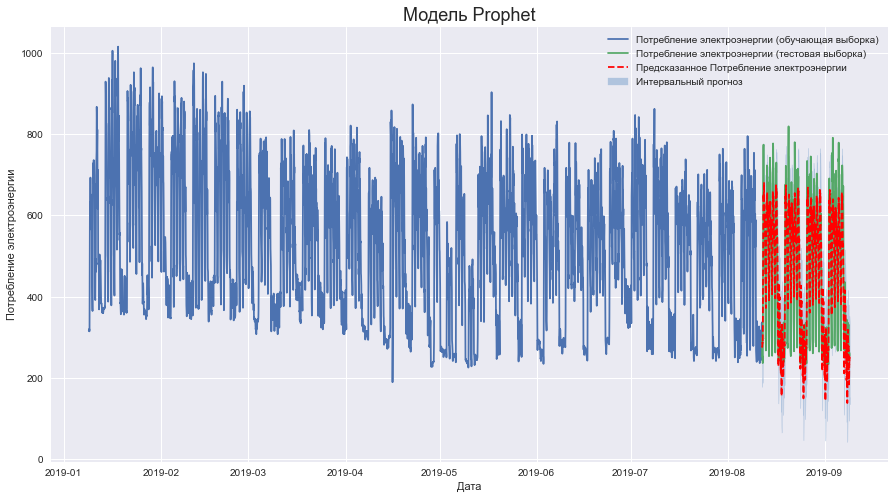

In [80]:
plt.figure(figsize=(15, 8))
plt.plot(df_train_3['ds'], df_train_3['y']);
plt.plot(df_test_3['ds'], df_test_3['y']);
plt.plot(pred_3_plt['ds'], pred_3_plt['y'], 'r--');
plt.fill_between(pred_3_interval['ds'], pred_3_interval['yhat_lower'], pred_3_interval['yhat_upper'], color='lightsteelblue')

plt.legend(['Потребление электроэнергии (обучающая выборка)','Потребление электроэнергии (тестовая выборка)', 'Предсказанное Потребление электроэнергии', 'Интервальный прогноз'])
plt.xlabel('Дата')
plt.ylabel('Потребление электроэнергии')
plt.title('Модель Prophet', size=18);

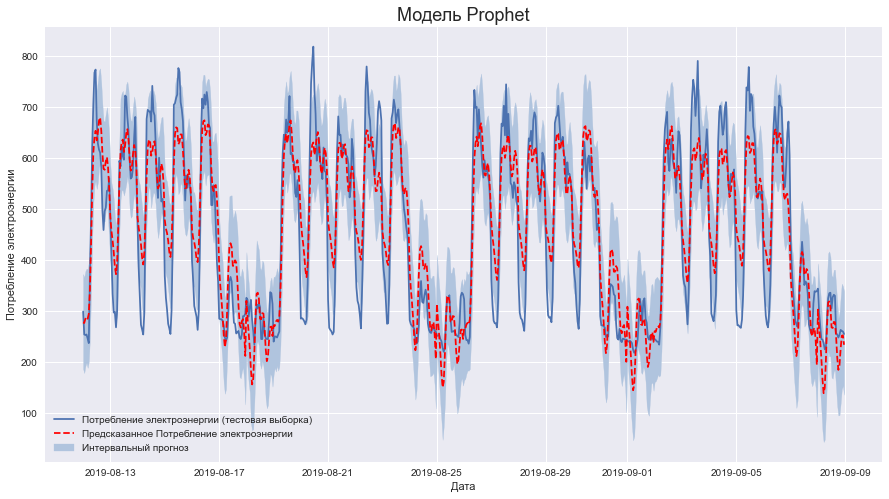

In [81]:
plt.figure(figsize=(15, 8))
plt.plot(df_test_3['ds'], df_test_3['y']);
plt.plot(pred_3_plt['ds'], pred_3_plt['y'], 'r--');
plt.fill_between(pred_3_interval['ds'], pred_3_interval['yhat_lower'], pred_3_interval['yhat_upper'], color='lightsteelblue')

plt.legend(['Потребление электроэнергии (тестовая выборка)', 'Предсказанное Потребление электроэнергии', 'Интервальный прогноз'])
plt.xlabel('Дата')
plt.ylabel('Потребление электроэнергии')
plt.title('Модель Prophet', size=18);

In [82]:
MSE_2 = mean_squared_error(df_test, pred_3_plt['y'])
 
RMSE_2 = math.sqrt(MSE_2)
print("Root Mean Square Error:\n")
print(RMSE_2)

Root Mean Square Error:

71.1210187142457


Из всех построенных моделей данная показывает лучший результат (судя по метрике RMSE). Однако если обратить внимание на график... Всё же на мой взгляд Модель Хольта-Винтерса описывает данные лучше. 

## 6. Предсказание

Итоговый csv файл будет сформирован на основе одной из двух лучших моделей.

### 6.1 Модель Хольта-Винтерса

In [83]:
df_1 = df[192:]
df_1

,fact
timestamp,
2019-01-09 00:00:00,317.0
2019-01-09 01:00:00,318.0
2019-01-09 02:00:00,319.0
2019-01-09 03:00:00,317.0
2019-01-09 04:00:00,321.0
...,...
2019-09-08 19:00:00,253.0
2019-09-08 20:00:00,263.0
2019-09-08 21:00:00,261.0


In [84]:
df_1.index = pd.DatetimeIndex(df_1.index.values,
                               freq='H')

In [85]:
final_model_1 = ExponentialSmoothing(df_1, seasonal_periods=336, trend=None, seasonal='add').fit()

In [86]:
final_model_pred_1 = final_model_1.predict(start='2019-09-09 00:00:00', end='2019-09-22 23:00:00')

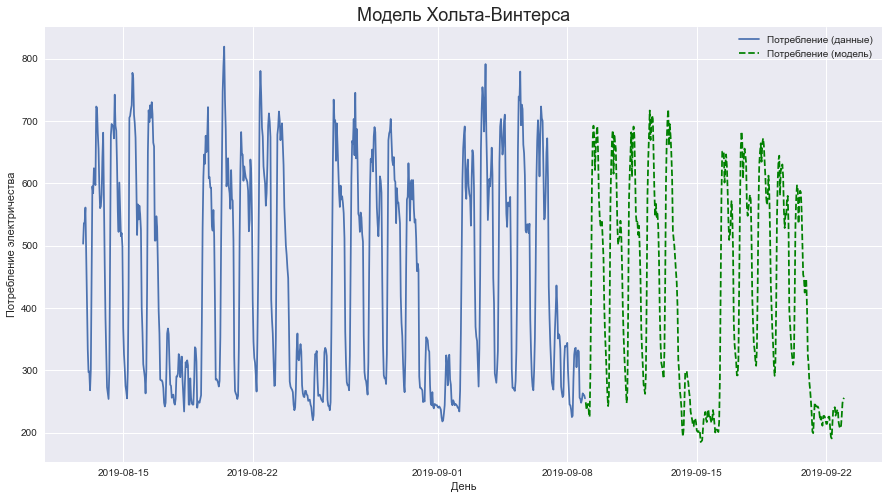

In [87]:
plt.figure(figsize=(15, 8))
plt.plot(df_1[5180:]);
plt.plot(final_model_pred_1, 'g--');
plt.legend(['Потребление (данные)', 'Потребление (модель)', 'Предсказанное потребление'])
plt.xlabel('День')
plt.ylabel('Потребление электричества')
plt.title('Модель Хольта-Винтерса', size=18);

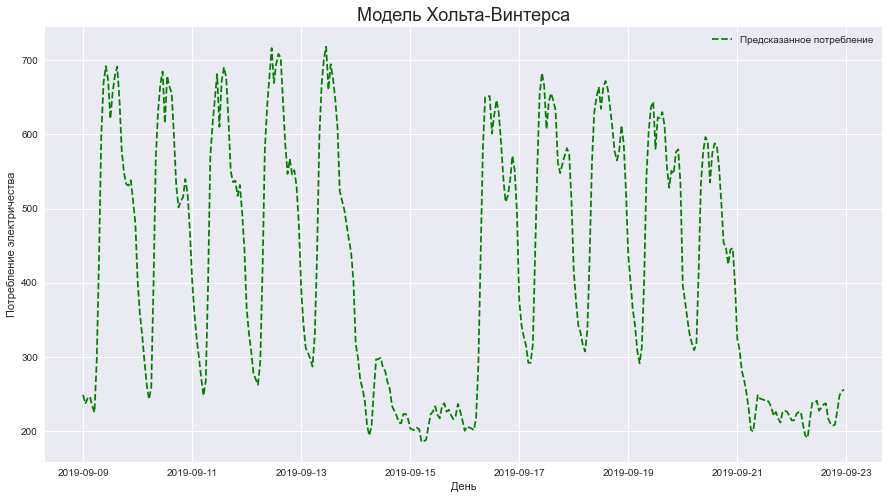

In [88]:
plt.figure(figsize=(15, 8))
plt.plot(final_model_pred_1, 'g--');
plt.legend(['Предсказанное потребление'])
plt.xlabel('День')
plt.ylabel('Потребление электричества')
plt.title('Модель Хольта-Винтерса', size=18);

In [89]:
final_model_pred_1

2019-09-09 00:00:00    248.680918
2019-09-09 01:00:00    236.569289
2019-09-09 02:00:00    244.054112
2019-09-09 03:00:00    246.275773
2019-09-09 04:00:00    233.462669
                          ...    
2019-09-22 19:00:00    208.408255
2019-09-22 20:00:00    226.413756
2019-09-22 21:00:00    247.600050
2019-09-22 22:00:00    253.665380
2019-09-22 23:00:00    255.843409
Freq: H, Length: 336, dtype: float64

### 6.2 Модель Prophet

In [90]:
df_2 = df_1.copy().rename(columns={'fact':'y'})

In [91]:
df_2['ds'] = df_2.index

Список праздников:

In [92]:
holidays = pd.DataFrame({
  'holiday': 'holy',
  'ds': pd.to_datetime(['2019-03-08', '2019-05-01','2019-05-02', '2019-05-09', '2019-05-10', '2019-06-12']),
  'lower_window': 0,
  'upper_window': 1,
})

Создаём регрессоры:

In [93]:
df_2['reg1'] = 0

Обычно пик работы приходится на дневное время суток. Самое большое значение потребления энергии примерно в 11 часов.

In [94]:
df_2['reg1'] = [1 if df_2['ds'][i].hour == 11 else 0 for i in df_2['ds']]

Раз был разговор про недельную сезонность. Попробуем это учесть

In [95]:
df_2['reg2']=df_2['ds'].dt.weekday

В воскресенье самое низкое значение потребления электроэнергии на неделе.

In [96]:
df_2['reg3'] = 0
df_2['reg3'] = [1 if x==6 else 0 for x in df_2['reg2']]

А во вторник самое активное.

In [97]:
df_2['reg4'] = 0
df_2['reg4'] = [1 if x==1 else 0 for x in df_2['reg2']]

Строим модельку:

In [98]:
final_model_2 = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=True,holidays=holidays,
                  n_changepoints=25, changepoint_range=0.7, seasonality_prior_scale=50.0, changepoint_prior_scale=0.1)
final_model_2.add_seasonality(name = 'custom_h', period = 7, fourier_order=5)
final_model_2.add_regressor('reg1')
final_model_2.add_regressor('reg2')
final_model_2.add_regressor('reg4')
final_model_2.add_country_holidays(country_name='RU')
final_model_2.fit(df_2)

Предсказываем:

In [99]:
final_model_pred_2 = final_model_2.make_future_dataframe(periods=336,freq='H')

In [100]:
final_model_pred_2['reg1'] = 0
for i in range(final_model_pred_1.shape[0]):
    if final_model_pred_2['ds'][i].hour == 11:
        final_model_pred_2['reg1'][i] = 1
    else:
        final_model_pred_2['reg1'][i] = 0

C:\Users\Vitaly\anaconda3\envs\msa\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Vitaly\anaconda3\envs\msa\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [101]:
final_model_pred_2['reg2']=final_model_pred_2['ds'].dt.weekday

In [102]:
final_model_pred_2['reg3'] = 0
final_model_pred_2['reg3'] = [1 if x==6 else 0 for x in final_model_pred_2['reg2']]

In [103]:
final_model_pred_2['reg4'] = 0
final_model_pred_2['reg4'] = [1 if x==1 else 0 for x in final_model_pred_2['reg2']]

In [104]:
final_model_pred_2

,ds,reg1,reg2,reg3,reg4
0,2019-01-09 00:00:00,0,2,0,0
1,2019-01-09 01:00:00,0,2,0,0
2,2019-01-09 02:00:00,0,2,0,0
3,2019-01-09 03:00:00,0,2,0,0
4,2019-01-09 04:00:00,0,2,0,0
...,...,...,...,...,...
6163,2019-09-22 19:00:00,0,6,1,0
6164,2019-09-22 20:00:00,0,6,1,0
6165,2019-09-22 21:00:00,0,6,1,0
6166,2019-09-22 22:00:00,0,6,1,0


In [105]:
final_model_pred_2 = final_model_2.predict(final_model_pred_2)

In [106]:
final_model_pred_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6168 entries, 0 to 6167
Data columns (total 70 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   ds                                    6168 non-null   datetime64[ns]
 1   trend                                 6168 non-null   float64       
 2   yhat_lower                            6168 non-null   float64       
 3   yhat_upper                            6168 non-null   float64       
 4   trend_lower                           6168 non-null   float64       
 5   trend_upper                           6168 non-null   float64       
 6   Christmas Day                         6168 non-null   float64       
 7   Christmas Day_lower                   6168 non-null   float64       
 8   Christmas Day_upper                   6168 non-null   float64       
 9   Defender of the Fatherland Day        6168 non-null   float64       
 10  

In [107]:
final_model_pred_2_plt = final_model_pred_2[['ds', 'yhat']].loc[5832:].rename(columns={'yhat':'y'})
final_model_pred_2_interval = final_model_pred_2[['ds', 'yhat_lower', 'yhat_upper']].loc[5832:]

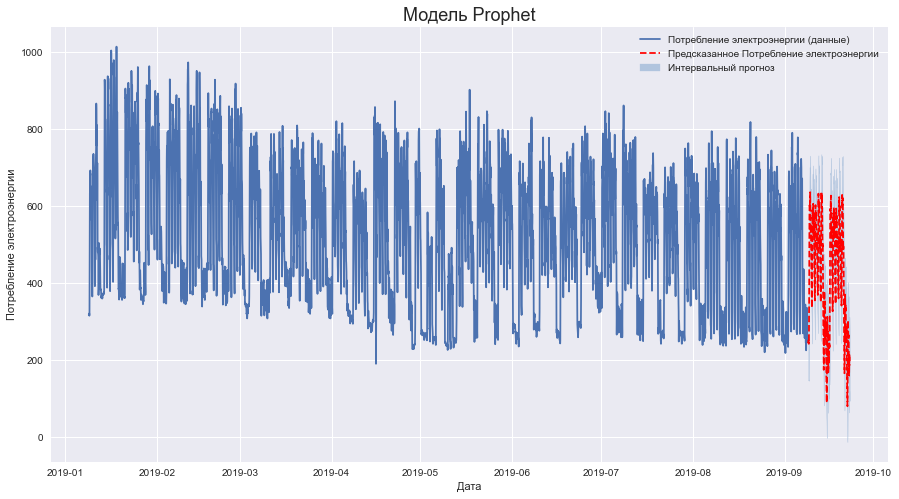

In [108]:
plt.figure(figsize=(15, 8))
plt.plot(df_2['ds'], df_2['y']);
plt.plot(final_model_pred_2_plt['ds'], final_model_pred_2_plt['y'], 'r--');
plt.fill_between(final_model_pred_2_interval['ds'], final_model_pred_2_interval['yhat_lower'], final_model_pred_2_interval['yhat_upper'], color='lightsteelblue')

plt.legend(['Потребление электроэнергии (данные)', 'Предсказанное Потребление электроэнергии', 'Интервальный прогноз'])
plt.xlabel('Дата')
plt.ylabel('Потребление электроэнергии')
plt.title('Модель Prophet', size=18);

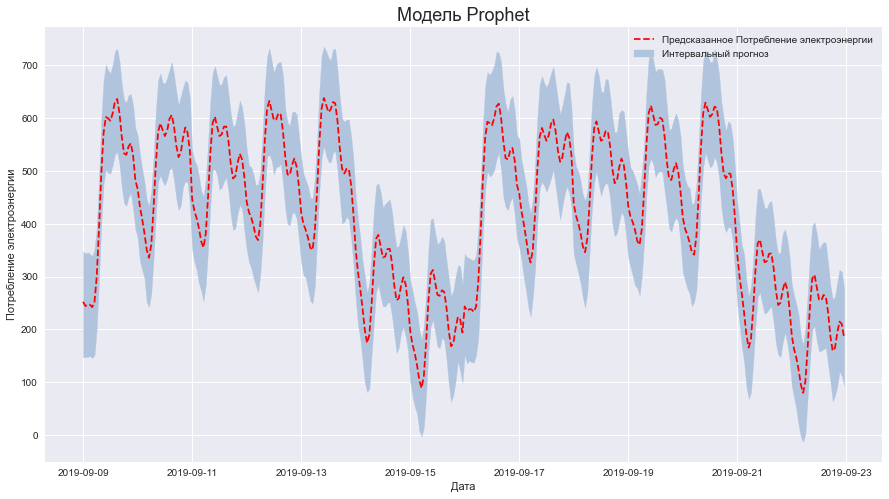

In [109]:
plt.figure(figsize=(15, 8))
plt.plot(final_model_pred_2_plt['ds'], final_model_pred_2_plt['y'], 'r--');
plt.fill_between(final_model_pred_2_interval['ds'], final_model_pred_2_interval['yhat_lower'], final_model_pred_2_interval['yhat_upper'], color='lightsteelblue')

plt.legend(['Предсказанное Потребление электроэнергии', 'Интервальный прогноз'])
plt.xlabel('Дата')
plt.ylabel('Потребление электроэнергии')
plt.title('Модель Prophet', size=18);

Сравним две модельки:

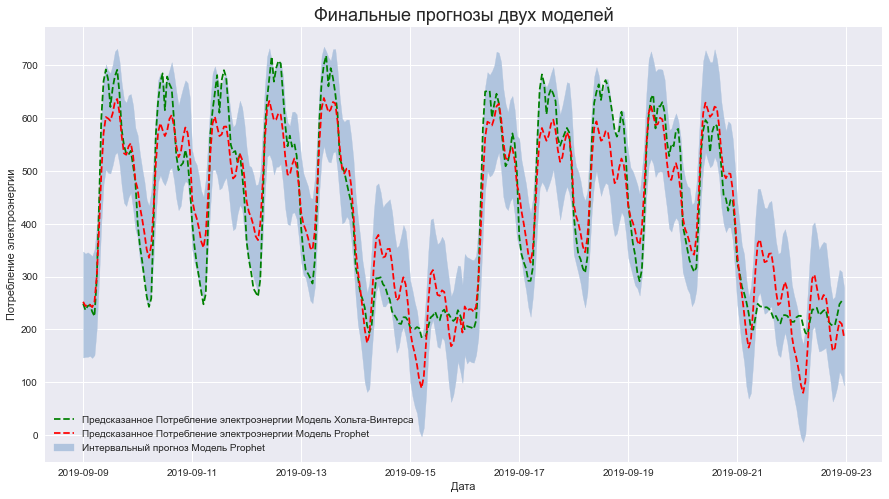

In [110]:
plt.figure(figsize=(15, 8))
plt.plot(final_model_pred_1, 'g--');
plt.plot(final_model_pred_2_plt['ds'], final_model_pred_2_plt['y'], 'r--');
plt.fill_between(final_model_pred_2_interval['ds'], final_model_pred_2_interval['yhat_lower'], final_model_pred_2_interval['yhat_upper'], color='lightsteelblue')

plt.legend(['Предсказанное Потребление электроэнергии Модель Хольта-Винтерса', 'Предсказанное Потребление электроэнергии Модель Prophet', 'Интервальный прогноз Модель Prophet'])
plt.xlabel('Дата')
plt.ylabel('Потребление электроэнергии')
plt.title('Финальные прогнозы двух моделей', size=18);

Всё же на мой субъективный взгляд модель Хольта-Винтерса лучше описывает временной ряд. Следовательно именно его и стоит записать как финальные предсказанные вероятности. Будет обидно, если на данном этапе окажется, что я не права)

In [111]:
final_model_pred_1.to_csv('Pletneva.csv')